### Processing and analyzing images
This notebook highlights some basic essentials with processing and analyzing simulated images with a mixed-field sample of simulated ERs and NRs

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm #progressbar
import matplotlib.pyplot as plt
'''Setting up some rcparameters for better size axis labels'''
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)

### Descriptions of each column (for people who use ROOT you'll hear columns being called "branches") in our dataframe:

-**nHits**: Number of primary electron tracks in the simulation

-**x**, **y**, **z**: Primary track x, y, and z coordinates

-**t**: Relative time of ionization deposit. (x,y,z) are sorted in time-order

-**flag**: Not so important. Flag indicates the physical process with which the ionization electron was generated: 1=fluorescence; 2=pair production; 3=bremsstrahlung; 0=otherwise

-**truth_dir**: (x,y,z) unit vector of track

-**truth_energy**: Energy of the primary track

-**ionization_energy**: ionization energy in CF4 of the primary track. This is computed as 'nHits' x W where W = 34.2 eV

-**truth_theta**: truth zenith angle (w.r.t z-axis) determined by 'truth_dir'

-**truth_phi**: truth aximuthal angle (in xy plane w.r.t +x) determined by 'truth_dir'

-**drift_length**: Amount of drift simulated. Currently using a random-uniform distribution between 1cm and 2.5cm. TODO for Jeff: Make this adjustable in configuration.yaml

-**xdiff**, **ydiff**, **zdiff**: x,y, and z coordinates of ionization after applying diffusion over 'drift_length'

-**xamp**, **yamp**, **zamp**: The electrons from (xdiff,ydiff,zdiff) that align with the openings of a GEM hole

-**xcam**, **ycam**, **qcam**: (x,y) after applying gain and diffusion through the transfer gap, binned to the 2048 x 1152 camera dimensions. 'qcam' is the number of amplified electrons falling into the bin

-**xITO**, **zITO**, **qITO**: (x,z) after applying gain and diffusion through the transfer gap, *and induction gap* binned to 120 strips along x. z is quantified assuming 0.26um per bin. 'qITO' is the number of amplified electrons falling into the ITO bin

In [2]:
'''Load data and combine into a single dataframe
you"ll have to change the directories to wherever you downloaded
the files to'''

ERs = pd.read_feather("data/20000ERs_2-11.8keV_processed.feather")
NRs = pd.read_feather("RCTRIM/output/F_maxE466.957_5489primaryTracks.feather")

'''NRs doesn"t have an nHits column, let"s add one'''
NRs['nHits'] = NRs['x'].apply(lambda x: len(x)) #Number of primary ionization electrons

In [3]:
'''Before we combine we should check the columns in the ER dataframe that aren"t in the NR dataframe'''
print(f"Columns not in NR: {[col for col in ERs.columns if col not in NRs.columns]}")
print(f"Columns not in ER: {[col for col in NRs.columns if col not in ERs.columns]}")

Columns not in NR: ['t', 'flag']
Columns not in ER: ['species']


In [4]:
'''Lets make NR['species'] = 1 and ER['species'] = 0
You can use this as the truth label for NRs and ERs respectively when performing
ML studies'''

NRs['species'] = 1
ERs['species'] = 0

'''Now let"s drop the ER columns that aren"t in the NR dataframe'''
ERs = ERs.drop(columns = ['t','flag'])

In [5]:
'''Now that the columns match, we can merge the dataframes'''
df = pd.concat([NRs,ERs]) #merge NRs and ERs
df = df.sample(frac = 1) #randomize entries of dataframe
df.index = [i for i in range(0,len(df))]

[Text(0.25, 0, 'ER'), Text(0.75, 0, 'NR')]

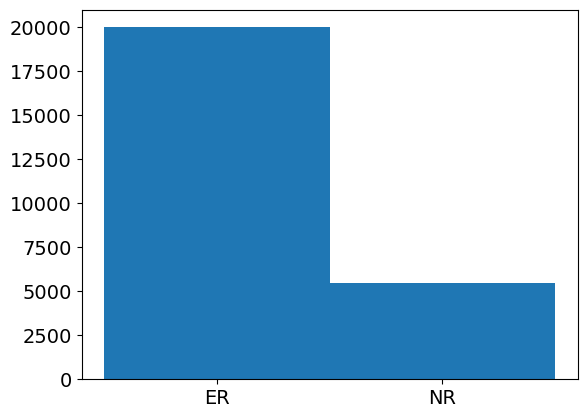

In [6]:
'''Let"s plot the species breakdown'''
fig,ax = plt.subplots()
ax.hist(df['species'],bins=2,range=(0,1))
ax.set_xticks([0.25,0.75])
ax.set_xticklabels(['ER','NR'])

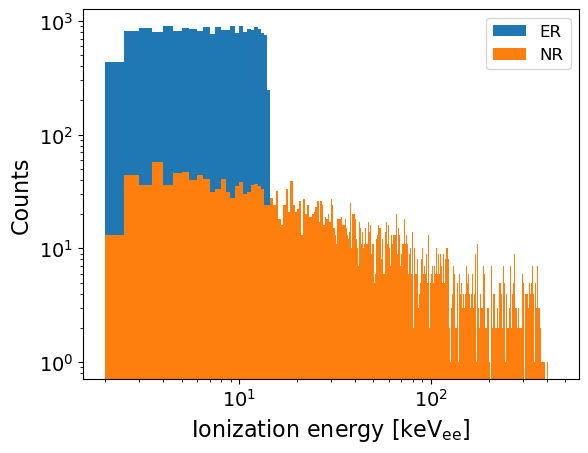

In [7]:
"""Now let's look at energy distributions"""
plt.hist(df.query('species == 0')['ionizationE'],bins=899,range = (2,450),label='ER')
plt.hist(df.query('species == 1')['ionizationE'],bins=899,range = (2,450),label='NR')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Ionization energy [$\rm keV_{ee}$]')
plt.ylabel('Counts')
plt.legend()

### Processing_images

Binned images are stored in "sparse" format as opposed to "dense" format. Sparse data includes (x,y,z,...) coordinate info for pixels > threshold value (we use 0 here). This means we ignore all 0's in our image.
This is computationally and storage efficient, as most of our image is empty (i.e. 0).

A 2048 x 1152 image of 16 bit pixels is 2048 x 1152 x 16 bits x 1 byte / 8 bits = 4.7 MB

On average, each image has around 7,000 non-zero pixels, so storing the image in sparse format gives:\
**2** & 7000 & 16 bits * 1byte / 8 bits = 28 kB **factor of 160 reduction over dense**

The bolded **2** comes from the fact that we're looking at x-y images, so we have 7000 16-bit integers for x and an additional 7000 16-bit integers for y

### Making images dense requires us binning them.
**It's actually computationally faster to bin sparse coordinates so sparsity helps us in many ways**

We'll be using [numpy's histogram2d function for this](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html)

In [11]:
df.query('truthE == 11.8')

,truthE,species,x,y,z,ionizationE,truth_dir,truth_theta,truth_phi,drift_length,...,xamp,yamp,zamp,xcam,ycam,qcam,xITO,zITO,qITO,nHits
110,11.8,0,"[-0.05437553644662499, -0.10990835338487134, -...","[-0.309582093169023, -0.31663019448614943, -0....","[1.1472574725945122, 1.192750367737514, 1.1762...",14.0904,"[-0.9810726071604816, -0.13307134961997025, -0...",1.711936,-3.006777,1.778791,...,"[-0.06288222164402611, -0.11609991388373343, -...","[-0.3141123256822609, -0.31431612150519783, -0...","[1.1170867802184046, 1.1981355118177495, 1.393...","[1020, 980, 982, 984, 985, 1028, 1029, 1032, 9...","[451, 452, 452, 452, 452, 452, 452, 452, 453, ...","[1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 2, 2, 1, 2, 1, ...","[58, 59, 60, 57, 58, 59, 60, 61, 56, 57, 58, 5...","[41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 4...","[60.0, 124.0, 8.0, 69.0, 4950.0, 16312.0, 1181...",412
285,11.8,0,"[-0.4917382651199309, -0.49205094005260963, -0...","[-0.6805551768279421, -0.6805080604910803, -0....","[0.49438722567874993, 0.4942663394367689, 0.51...",15.0480,"[0.8143244498237759, 0.26683379688835285, 0.51...",1.029279,0.316649,1.160760,...,"[-0.4254163523355871, -0.37559800541568056, -0...","[-0.654190654064111, -0.6566261395119732, -0.6...","[0.5519860996947754, 0.5648571080595858, 0.562...","[882, 878, 880, 885, 886, 887, 889, 875, 878, ...","[365, 366, 366, 367, 367, 367, 367, 368, 368, ...","[1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, ...","[52, 53, 54, 52, 53, 54, 51, 52, 53, 54, 55, 5...","[15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 1...","[14.0, 26.0, 2.0, 1374.0, 6291.0, 744.0, 6.0, ...",440
293,11.8,0,"[0.2984718441372165, 0.3152281683280008, 0.294...","[-0.9762719753585315, -1.0195884018151096, -0....","[1.4129132275022573, 1.4327117121618127, 1.403...",13.9194,"[-0.1468270643059889, -0.9059114213573716, 0.3...",1.162335,-1.731476,1.617866,...,"[0.2838328764709851, 0.3909400166290709, 0.559...","[-1.026168701617405, -1.0163858589853776, -0.7...","[1.4265382779426448, 1.4612871880543141, 1.809...","[1101, 1100, 1104, 1105, 1106, 1100, 1101, 110...","[270, 272, 272, 272, 272, 273, 273, 273, 273, ...","[1, 1, 3, 1, 1, 2, 2, 4, 7, 4, 4, 2, 1, 1, 8, ...","[62, 63, 64, 62, 63, 64, 65, 62, 63, 64, 65, 6...","[53, 53, 53, 54, 54, 54, 54, 55, 55, 55, 55, 5...","[2.0, 70.0, 14.0, 828.0, 8912.0, 1802.0, 54.0,...",407
344,11.8,0,"[0.7190744567882036, 0.696961918755806, 0.6087...","[-0.15310364650918115, -0.13552645853061435, -...","[1.521594243050619, 1.5563817099984294, 1.6648...",13.5432,"[-0.4013070410732722, 0.7101955812035059, 0.57...",0.954000,2.085133,1.720729,...,"[0.5033619921587486, 0.3635806623820166, 0.115...","[-0.1214097857169572, -0.12011653526848397, -0...","[1.7103704615276754, 1.764507896522361, 1.6222...","[1042, 1044, 1045, 1003, 1041, 1042, 1043, 104...","[495, 495, 495, 496, 496, 496, 496, 496, 496, ...","[1, 2, 1, 1, 1, 2, 2, 5, 4, 3, 2, 3, 1, 1, 1, ...","[68, 60, 66, 67, 68, 69, 58, 59, 60, 61, 62, 6...","[56, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 5...","[2.0, 2.0, 5.0, 200.0, 1812.0, 154.0, 45.0, 10...",396
374,11.8,0,"[0.48678616729238494, 0.4894801008553933, 0.33...","[0.601816102529478, 0.5971418980417154, 0.5363...","[1.8717420315626003, 1.8705596165019853, 1.749...",14.0562,"[-0.4346693195052, 0.8720423743805511, 0.22495...",1.343900,2.033203,1.628361,...,"[0.29873243131526206, 0.2983076656007145, 0.34...","[0.5490513228791393, 0.5091486082376141, 0.484...","[1.740662754363855, 1.734991062101791, 1.66358...","[958, 1006, 1007, 1011, 957, 980, 991, 997, 10...","[474, 474, 474, 474, 475, 475, 475, 475, 475, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...","[56, 57, 55, 56, 57, 58, 55, 56, 57, 58, 59, 6...","[55, 55, 56, 56, 56, 56, 57, 57, 57, 57, 57, 5...","[38.0, 34.0, 31.0, 7045.0, 9092.0, 68.0, 2112....",411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25320,11.8,0,"[-0.4621447539254339, -0.46081126867539857, -0...","[0.6812407411736487, 0.6679001929848091, 0.695...","[1.56929

In [15]:
# converting sparse coordinates to dense coordinates. Use np.histogram2d

eventnum = 285 #let's look at event number 0

event = df.iloc[eventnum] #grab the event

#Declaring each argument for clarity. Native bin size is (2048,1152). xcam, and ycam
#are already binned to 0-2047 and 0-1151, respectively
#The function reference shows that argument 0 of the function is the 2D histogram (ndarray)

im = np.histogram2d(x=event['xcam'],y=event['ycam'],weights=event['qcam'],
                   bins=(2048,1152),range=((0,2048),(0,1152)))[0].T #transpose makes x and y as they should be

In [16]:
np.shape(im) #image shape is what we want

(1152, 2048)

(355.0, 692.0)

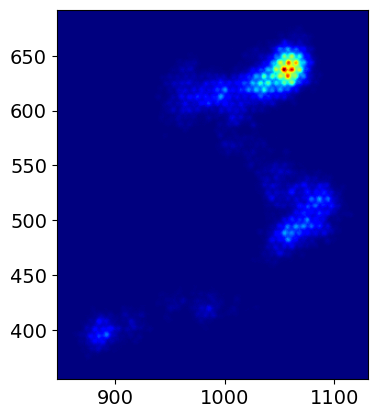

In [17]:
# Colormap reference https://matplotlib.org/stable/users/explain/colors/colormaps.html

#Our group uses 'jet' for historical reasons. We really should use a perceptually uniform sequential
#colormap like 'viridis' or 'plasma'
plt.imshow(im,cmap='jet')
plt.xlim(event['xcam'].min()-10,event['xcam'].max()+10)
plt.ylim(event['ycam'].min()-10,event['ycam'].max()+10)

In [26]:
'''Lets make a function to efficiently bin images'''

#bin_factor is the factor we downsample the image by. For example
#bin_factor = 4 is 4x4 binning
def bin_image(i,bin_factor):
    tmp = df.iloc[i]
    im = np.histogram2d(x=tmp['xcam'],y=tmp['ycam'],weights=tmp['qcam'],
                   bins=(2048//bin_factor,1152//bin_factor),
                        range=((0,2048),(0,1152)))[0].T #transpose makes x and y as they should be
    return im

(88.0, 173.0)

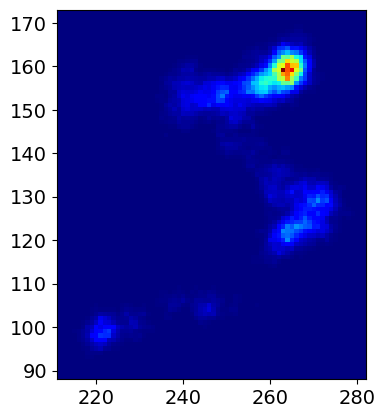

In [28]:
bin_fact = 4
plt.imshow(bin_image(eventnum,bin_factor = bin_fact),cmap='jet')
plt.xlim((event['xcam'].min()-10)//bin_fact,(event['xcam'].max()+10)//bin_fact)
plt.ylim((event['ycam'].min()-10)//bin_fact,(event['ycam'].max()+10)//bin_fact)

### We've seen examples of plotting tracks, but for electron rejection, we want to come up with discriminates that can be used to reject ERs and keep NRs

As an example let's compute the length of tracks in about the most rudimentary way we can think of. We could simply compute the length of the diagonal of the smallest bounding box fully containing each track

In [30]:
'''The smallest bounding box is the box whose perimeter is defined by the minimum x and y coordinates
Let"s compute the x and y extrema for each event'''

df['xmin'] = df['xcam'].apply(lambda x: x.min()) #minimum on camera readout
df['ymin'] = df['ycam'].apply(lambda x: x.min()) #minimum on camera readout
df['xmax'] = df['xcam'].apply(lambda x: x.max()) #maximum on camera readout
df['ymax'] = df['ycam'].apply(lambda x: x.max()) #maximum on camera readout

In [35]:
'''Now lets compute this length and convert to mm'''

df['crude_length'] = np.sqrt((df['xmax']-df['xmin'])**2+(df['ymax']-df['ymin'])**2)*80/2048 #mm

(355.0, 692.0)

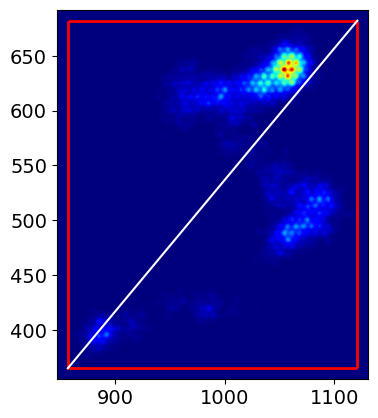

In [34]:
'''Just for fun lets plot this length on our track'''
event = df.iloc[eventnum]
plt.imshow(im,cmap='jet')
'''plot bounding box'''
plt.hlines(event['ymin'],event['xmin'],event['xmax'],color='red',lw=2) #bottom horiz line
plt.hlines(event['ymax'],event['xmin'],event['xmax'],color='red',lw=2) #top horiz line
plt.vlines(event['xmin'],event['ymin'],event['ymax'],color='red',lw=2) #left vert line
plt.vlines(event['xmax'],event['ymin'],event['ymax'],color='red',lw=2) #right vert line
'''plot length'''
plt.plot([event['xmin'],event['xmax']],[event['ymin'],event['ymax']],color='w')
plt.xlim(event['xcam'].min()-10,event['xcam'].max()+10)
plt.ylim(event['ycam'].min()-10,event['ycam'].max()+10)

### The above is a pretty poor approximation but its a start

Now lets see how well length does as a discriminant

Text(0.5, 0, 'Length of bounding box diag [mm]')

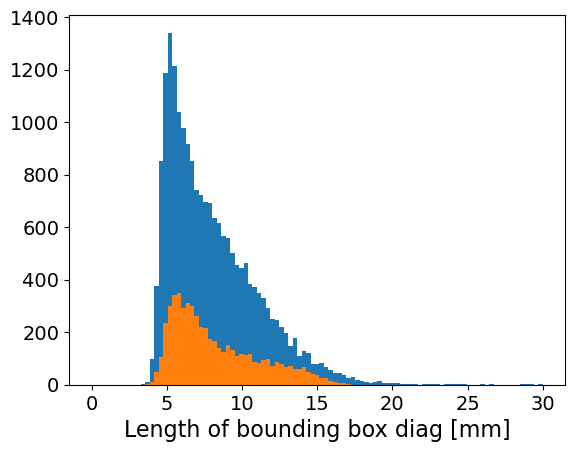

In [39]:
plt.hist(df.query('species == 0')['crude_length'],bins=101,range=(0,30),label='ER')
plt.hist(df.query('species == 1')['crude_length'],bins=101,range=(0,30),label='NR')
plt.xlabel('Length of bounding box diag [mm]')

### What if we add energy into the mix

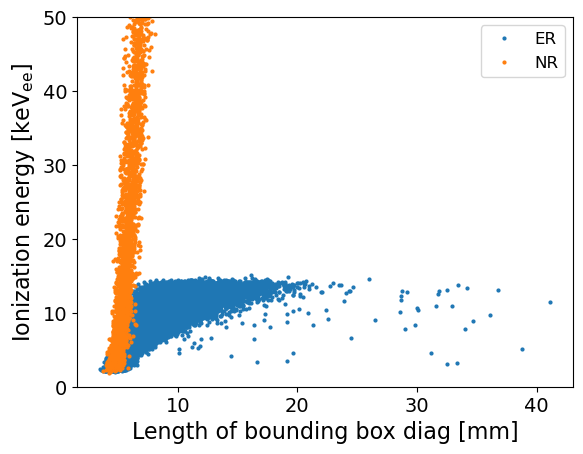

In [45]:
plt.plot(df.query('species == 0')['crude_length'],df.query('species == 0')['ionizationE'],'o',label = 'ER',markersize = 2)
plt.plot(df.query('species == 1')['crude_length'],df.query('species == 1')['ionizationE'],'o',label = 'NR',markersize = 2)
plt.xlabel('Length of bounding box diag [mm]')
plt.ylabel(r'Ionization energy [$\rm keV_{ee}$]')
plt.ylim(0,50)
plt.legend()

### Now we're getting somewhere!